# Extended data supporting the study of rundown experiments on L-type calcium current

This notebook provides supporting material that supplements the understanding of the methods undertaken and the results obtained in this study in Sections A, B, and C

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import helpers
import extensions

out_dir = ['BT_10', 'BT_20', 'BT_40', 'RT_10', 'RT_20', 'RT_40']

### A. Supporting material for methods

This section shows the relationship between $g_{leak}$ and $R_{seal}$ (Section A.1) and the number of cells selected by the quality control criteria (Section A.2).

##### A.1 $g_{leak}$ dependence on $R_{seal}$

The strength of the leak current in the patch-clamp setup used in this study is affected by how well the cell is attached to the chip-plate.
Therefore, the leak conductance is inversely dependent on the seal resistance as shown in the scatter plot below.

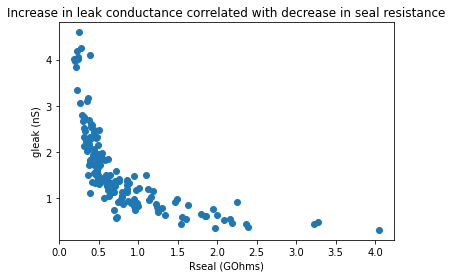

In [11]:
#### Plot that shows the inverse relationship between Rseal and gleak
rseal_arr = []
gleak_arr = []
for dir in out_dir:
    files = os.listdir(f'output/{dir}')
    for f in files:
        if f[:4] == 'prop':
            data = pd.read_csv(f'output/{dir}/{f}')
            gleak = data['gleak (nS)'].median()
            rseal = data['rseal (GOhms)'].median()
            rseal_arr.append(rseal)
            gleak_arr.append(gleak)

fig = plt.figure(facecolor='white')
plt.scatter(rseal_arr, gleak_arr)
plt.xlabel('Rseal (GOhms)')
plt.ylabel('gleak (nS)')
plt.title('Increase in leak conductance correlated with decrease in seal resistance')
plt.show()
plt.close()

##### A.2 Number of cells selected

The number of cells selected from each chip plate by applying different QC mentioned in the main papaer are given below

In [12]:
extensions.select_cell_per_qc()

temp hold | QC0 QC1.1 QC1.2 QC1.3 QC2.1 QC2.2 QC3 QC4 QC5 | SELECTED
-----------------------------------------------------------------
BT 10 | 74 63 74 74 65 46 48 73 70 | 36
BT 20 | 50 44 50 48 43 37 34 47 45 | 24
BT 40 | 52 37 50 48 43 26 31 50 49 | 18
RT 10 | 44 43 44 44 39 31 19 44 42 | 18
RT 20 | 56 55 56 55 55 43 40 55 56 | 35
RT 40 | 40 37 40 36 40 31 32 38 40 | 25


### B. Supporting material for results

This section covers some basic checks to understand the level of rundown, its shape, and the rundown rate (Section B.1), investigate the rundown rate per pulse (Section B.2), and finally perform some checks on the multi-linear regression analysis presented in the paper (Section B.3).

##### B.1 Basic checks to understand results

Examine the results to determine the level of rundown obtained, split the cells according to the shape of their rundown-versus-time curve, and the rate of rundown.

In [13]:
## rundown data basic check
final_run = []
for dir in out_dir:
    fname = f'output/{dir}/'
    files = os.listdir(fname)
    for f in files:
        if f[4:] == 'csv':
            data = pd.read_csv(fname + f'{f}').min(axis=0)
            final_run.append(data.iloc[-1]/data.iloc[0])

print(f"On an average, current is reduced to {np.median(final_run)*100}% of its initial value")
print(f"The minimum reduction was to {np.max(final_run)*100}%, while the maximum reduction was to {np.min(final_run)*100}% of its initial value")
            

On an average, current is reduced to 62.9104555478861% of its initial value
The minimum reduction was to 244.20186055996527%, while the maximum reduction was to 13.668249821217938% of its initial value


In [14]:
# Load relevant data
data = pd.read_csv('output/r_rate_database.csv')
r_rate = data['Run rate']

print(f"On an average, current is reduced at the rate of {np.median(r_rate)} per min")

On an average, current is reduced at the rate of 0.07678519659722655 per min


In [15]:
## Rundown versus time curve
shape = data['shape']
linear = len(shape[shape == 'Linear'])
saturating = len(shape[shape == 'Saturating'])
other = len(shape[shape == 'Other'])
total = linear + saturating + other

print('Percentage of cells exhibiting a linear function: ', 100*linear/total)
print('Percentage of cells exhibiting a saturating function: ', 100*saturating/total)
print('Percentage of cells exibiting other functions: ', 100*other/total)



Percentage of cells exhibiting a linear function:  35.256410256410255
Percentage of cells exhibiting a saturating function:  21.794871794871796
Percentage of cells exibiting other functions:  42.94871794871795


##### B.2 Rundown per pulse

For each experimental condition, we find that the rundown per pulse (or sweep) is more for the experiemntal condition at which the there are lesser number of pulses, suggesting that a significant amount of rundown occurs due to time-dependent processes.

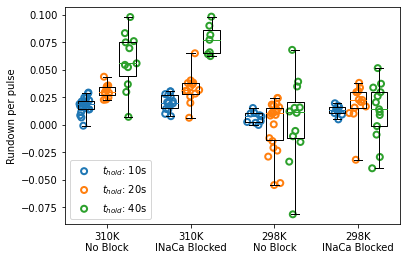

In [16]:
fig = helpers.rundown_per_pulse()
plt.show()
plt.close()

##### B.3 Regression checks

Here we calculated the rundown rate predicetd by the model and used it to estimate the residuals.
These were then used to check four assumptions of performing a multi-linear regression.

1. Linearity: Ideally the scatter plot of predicted versus actual values should lie exactly on a diagnol. While this is not completely true for the plot shown in this section, the variation is horizontally on both sides of the diagnol which is expected given that temperature and INaCa are used as discrete rather than continuous variables.
2. Normality: The residuals form part of a normal-like distribution with a slight skew on the right side, however, given the complexity of the data, this is not too concerning.
3. Non-autocorrelation: The Durbin-Watson test was performed on the residuals which passed and confirmed that the errors are not auto-correlated
4. Homoscedasticity: The residuals do not have a constant variance throughout which can again be attributed to the fact that some of the variables of the model are discrete rather than continuous.

While all the assmptions of the linear regression are not satisfied, this can be attributed to several factors including: 1) there are several over fctors that affect the calcium concentration inside a cell, 2) there are factors besides intracellular calcium that affect rundown, and 3) the nature of some of the variables in this study only allows them to be observed at discrete rather than continuous values.

Since the purpose of the regression model is not to determine a value given the observations of temperature, $t_{hold}$, and INaCa; but rather to confirm the direction of the relationship of each of these factors towards rundown and to determine their statistical significance, this regression is fit for purpose.


In [17]:
# defaults: INaCa_off = 0, INaCa_on = 1; temp_310 = 0, temp_298 = 1
# equation: r_rate = b_0 + b_1 * (log(thold)) + b_2 * (INaCA_On)  + b_3 * (temp_298)
b_0, b_1, b_2, b_3 = 0.158795, -0.016373, -0.021030, -0.062213

res_arr = []
r_rate_pred_arr = []

for i in range(len(data)):
    thold = np.log(data.iloc[i]['thold'])

    if data.iloc[i]['Temperature'] == 310:
        temp = 0
    elif data.iloc[i]['Temperature'] == 298:
        temp = 1
    else:
        raise ValueError ('Temperature is not defined')

    if data.iloc[i]['INaCa'] == 'Off':
        inaca = 0
    elif data.iloc[i]['INaCa'] == 'On':
        inaca = 1
    else:
        raise ValueError ('INaCa is not defined')

    r_rate_pred = b_0 + b_1 * thold + b_2 * inaca + b_3 * temp
    r_rate_actual = data.iloc[i]['Run rate']
    res_cell = r_rate_pred - r_rate_actual
    res_arr.append(res_cell)
    r_rate_pred_arr.append(r_rate_pred)

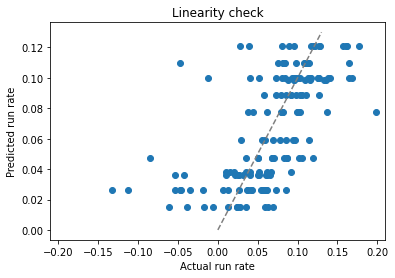

In [18]:
# Assumption 1: Linearity
fig = plt.figure(facecolor='white')
arr = np.arange(0, 0.131, 0.002)
plt.scatter(data['Run rate'], r_rate_pred_arr, color = 'tab:blue')
plt.plot(arr, arr, color = 'grey', ls = '--')
plt.xlabel('Actual run rate')
plt.ylabel('Predicted run rate')
plt.xlim(-0.21, 0.21)
plt.title('Linearity check')
plt.show()
plt.close()

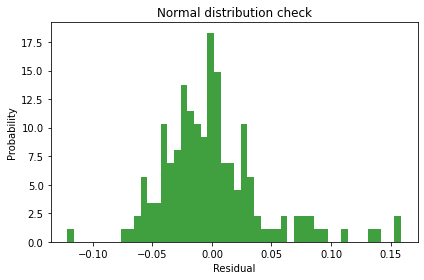

In [19]:
# Assumption 2: Normality
res_pd = pd.DataFrame(pd.DataFrame(res_arr))
fig = plt.figure(facecolor='white')
ax2 = fig.add_subplot(111)

ax2.hist(res_pd, 50, density=True, facecolor='g', alpha=0.75)
ax2.set_xlabel('Residual')
ax2.set_ylabel('Probability')
ax2.set_title('Normal distribution check')

plt.tight_layout()
plt.show()
plt.close()

In [20]:
# Assumption 3: Auto-correlation of errors

from statsmodels.stats.stattools import durbin_watson

val = durbin_watson(res_arr)
# Autocorelation
print(f'The output of Durbin-Watson test is: {val}')

if  1.5 < val < 2.5:
    print("No autocorrelation of error and the test has passed") 
else:
    print("Error autocorrelated and the test has failed")


The output of Durbin-Watson test is: 1.968424036140333
No autocorrelation of error and the test has passed


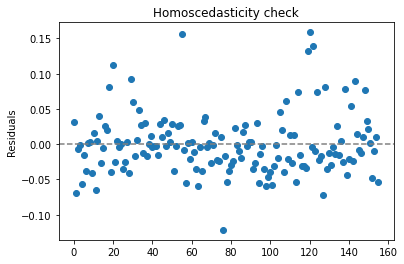

In [21]:
# Assumption 4: Homoscedasticity - residuals should have constant variance

fig = plt.figure(facecolor='white')

arr = np.arange(0, len(res_arr), 1)

plt.scatter(arr, res_arr, color = 'tab:blue')

plt.axhline(0, color = 'grey', ls = '--')
plt.ylabel('Residuals')

plt.title('Homoscedasticity check')
plt.show()
plt.close()

### C. Estimation of calcium accumulation inside the cell and Supporting material for results

The differences across the experimental conditions account for only 39% of the variability in $R'$ observed across the cells. 
This suggests that there must be some other factors that contribute towards rundown in these experiments. 
A possible reason for the cell-to-cell differences in $R'$ can be due to differing levels of CaV1.2 expression on a cell resulting in varying levels of $[\text{Ca}^{2+}]$ in the cellular submembrane.

This section shows the estimation of number of calcium ions that enter the cell (Section C.1) and the effective calcium concentration along with the corelation between the rundown rate and calcium concentration (Section C.2). 

##### C.1 Estimation of number of calcium ions entering the cell


The total number of moles of incoming $\text{Ca}^{2+}$ ($\text{N}_{\text{Ca}}$) brought into the cell carried by ICaL and leak current can be calculated using the equation below:

$\text{N}_{\text{Ca}} = - \frac{\int_{0}^{t}I\,dt}{2F}$,

where $t$ is the total duration of the experiment before the addition of nifedipine.


The estimation of $\text{N}_{\text{Ca}}$ brought in via ICaL is straightforward. However, not all of leak current occurs due to calcium ions.

Ileak is carried by all the free ions and charged molecules that flow in and out of the cell through a hole caused by an imperfect seal (indicated by a low ${R}_{seal}$) between the well on the chip and the cell's membrane. 
While the Ileak in any sweep can be calculated by the method described in the 'Post-processing' section of the main article, in this section, an equation is derived to estimate the fraction of Ileak carried by any ion $X$, with a special interest in $\text{Ca}^{2+}$.

There are seven different ionic species in the solutions used in this study as shown in the table below.

| Ion | Definition | Value |
| :----: | :----: | :----: |
| $[\text{K}^{+}]_i$ | Intracellular potassium concentration | 110 mM |
| $[\text{K}^{+}]_o$ | Extracellular potassium concentration | 3.5 mM |
| $[\text{Na}^{+}]_i$| Intracellular sodium concentration | 9.1 mM |
| $[\text{Na}^{+}]_o$| Extracellular sodium concentration | 78.75 mM|
| $[\text{Cs}^{+}]_i$| Intracellular caesium concentration| 0 mM |
| $[\text{Cs}^{+}]_o$| Extracellular caesium concentration| 0.5 mM|
| $[\text{Mg}^{2+}]_i$| Intracellular magnesium concentration| 0 mM|
| $[\text{Mg}^{2+}]_o$| Extracellular magnesium concentration| 1 mM|
| $[\text{Cl}^{-}]_i$ | Intracellular chloride concentration | 15 mM|
| $[\text{Cl}^{-}]_o$ | Extracellular chloride concentration | 89.05 mM|
| $[\text{F}^{-}]_i$ | Intracellular fluoride concentration | 100 mM|
| $[\text{F}^{-}]_o$ | Extracellular fluoride concentration | 0 mM|
| $[\text{Ca}^{2+}]_o$ | Extracellular calcium concentration| 2.15 mM|

Therefore, Ileak can be re-written as: 

$I_{leak} = I_{leakK} + I_{leakNa} + I_{leakCl} + I_{leakF} + I_{leakCa} + I_{leakCs} + I_{leakMg}$

The flux due to each ion is assumed to be independent of the other and each ion diffuses over a length $L$.
Therefore, the current density ($I_X$) due to any ion $X$ can be re-written as the modified Goldman-Hodgkin-Katz flux equation:

$I_X = {\frac{D_X}{L}}\frac{V_mz^2_X F^{2}}{R_gT}(\frac{\gamma_i[X]_i - \gamma_o[X]_o \exp{(-z_X V_mF/R_gT)}}{1 - \exp{(-z_X V_mF/R_gT)}})$

Here $D_X/L$ is the permeability of the LCCs, where $D_X$ is the diffusion coefficient, $L$ is the length of the channel, $z_X$ is the valency of ion $X$, $F$ is Faraday's constant, $R_g$ is the universal gas constant, and $T$ is the temperature.
$\gamma$ represents the deviation of ionic species from ionic behaviour and is calculated using the empirical formulation given by Davies et. al. 1964.
Next, by assuming that the Stokes-Einstein equation is valid (holds true for spherical solutes that are much larger than the solvent), $D_X$ can be replaced with $\frac{kT}{6\pi \mu a_X}$, where $a_X$ is the radius of the ionic species $X$, $k$ is the Boltzmann constant, and $\mu$ is the viscosity of the solvent to get the equation below:

$I_X = \frac{F^2k}{R_gL6\pi \mu}\frac{z_X^2V_m}{a_X}(\frac{\gamma_i[X]_i - \gamma_o[X]_o\exp{(-{z_XFV_m}/{R_gT})}}{1 - \exp({{-{z_XFV_m}/{R_gT}}})})$.

As per the equation above, while $L$ and $\mu$ remain constant as the experiment progresses, the leak current carried by any ion is proportional to a factor given by:

$\text{X}_{\text{{eff}}} = \frac{z_X^2V_m}{a_X}(\frac{\gamma_i[X]_i - \gamma_o[X]_o\exp{(-{z_XFV_m}/{R_gT})}}{1 - \exp({{-{z_XFV_m}/{R_gT}}})})$.

This can be plugged back into the total leak equation to estimate the effective Ileak carried by any single ion $X$ as:
$\text{I}_{\text{leakX}} = \frac{\text{X}_{\text{{eff}}}}{\sum \text{X}_{\text{{eff}}}} {\text{I}}_{\text{{leak}}}$

Contants and terms used to to estimate $X_{eff}$ are given below:

| Term | Definition | Value |
| :----: | :----: | :----: |
| $A_0$ | Davies equation constant | 1.82 X $10^{6}$ |
| $\epsilon$ | Dielectric constant | 74|
| R | Gas constant (J/mol/K) | 8.314472 |
| T | Temperature (K) | 298 or 310 |
| $a_{\text{K}}$ | Effective ionic radius of [K\textsuperscript{+}] | 138 pm |
| $a_{\text{Na}}$| Effective ionic radius of [Na\textsuperscript{+}]| 102 pm |
| $a_{\text{Cl}}$| Effective ionic radius of [Cl\textsuperscript{-}]| 181 pm |
| $a_{\text{F}}$ | Effective ionic radius of [F\textsuperscript{-}] | 133 pm |
| $a_{\text{Ca}}$| Effective ionic radius of [Ca\textsuperscript{2+}]| 100 pm|
| $a_{\text{Mg}}$| Effective ionic radius of [Mg\textsuperscript{2+}]| 72 pm  |
| $a_{\text{Cs}}$| Effective ionic radius of [Cs\textsuperscript{+}] | 167 pm |

The derivation for $X_{eff}$ in the study suggests that leak due to individual ions varies non-linearly with respect to volatge.
However, the leak current itself has been derived by assuming a linear dependence on voltage (Equation 1 in the paper).
This contradiction is resolved by plotting the total $X_{eff}$ against voltage and observing that while leak due to individual ions such as Na, Ca, K, varies non-linearly with voltage, the sum of $X_{eff}$ due to all ions in the solution varies linearly with voltage.
$X_{eff}$ can therefore be used to estimate the leak current due to calcium.

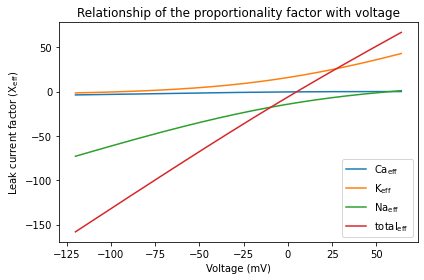

In [22]:
#### Plot showing that derived leak is linear

volt_arr = [i for i in range(-120, 65, 1)]
volt_arr = [volt + 0.01 for volt in volt_arr]
volt_arr = pd.DataFrame(volt_arr, columns = ['Voltage'])

X_K, X_Na, X_Ca, _, _, _, _, X_tot = \
    helpers.leak_proportion_calcium('BT', volt_arr['Voltage'])

fig = plt.figure(facecolor='white')
plt.plot(volt_arr, X_Ca, label = '$\mathregular{Ca_{eff}}$')
plt.plot(volt_arr, X_K, label = '$\mathregular{K_{eff}}$')
plt.plot(volt_arr, X_Na, label = '$\mathregular{Na_{eff}}$')
plt.plot(volt_arr, X_tot, label = '$\mathregular{total_{eff}}$')

plt.legend()
plt.xlabel('Voltage (mV)')
plt.ylabel('Leak current factor ($\mathregular{X_{eff}}$)')
plt.title('Relationship of the proportionality factor with voltage')
plt.tight_layout()
plt.show()
plt.close()

In [23]:
_, _, X_Ca, _, _, _, _, total = \
    helpers.leak_proportion_calcium('BT', pd.DataFrame([-90])[0])
X_hold = X_Ca/total
_, _, X_Ca, _, _, _, _, total = \
    helpers.leak_proportion_calcium('BT', pd.DataFrame([-0.0001])[0])
X_step = X_Ca/total

print(f'At the holding potential of -90 mV, {round(X_hold[0]*100, 2)}% of the leak current is due to movement of calcium ions')
print(f'At the step voltage of of 0 mV, {round(X_step[0]*100, 2)}% of the leak current is due to movement of calcium ions')

At the holding potential of -90 mV, 2.41% of the leak current is due to movement of calcium ions
At the step voltage of of 0 mV, 7.01% of the leak current is due to movement of calcium ions


##### C.2 Effective submembrane calcium concentration

The effective submembrane calcium concentration was estimated using an approximate for the volume of each cell.

While the exact measurements for each cell were not available, the capacitance recorded for each cell (${C}_{m}$) was instead used as an indication of the cell's volume.
The surface area (A) of the cell can be assumed to be proportional to ${C}_{m}$ because $A \propto C_m/C_s$.
The specific capacitance ($C_s$) is often taken as a constant equal to 1 microF/$\text{cm}^2$. 
For a cell of approximately spherical shape with radius $R_0$, $4\pi R_0^2\,\propto\,C_m \implies R_0\,\propto\,C_m^{{1}/{2}}$. 
Therefore, cell volumes which are proportional to $R_0^3$ should be proportional to $C_m^{{3}/{2}}$.

The intracellular $[\text{Ca}^{2+}]$ can be approximated by ${N}_{\text{\textit{Ca}}}/C_m^{3/2}$ (fmol/$\text{pF}^{3/2}$), since the volume of the cell is assumed to be proportional to $C_m^{{3}/{2}}$. 

While it is difficult to calculate the `local' submembrane $[\text{Ca}^{2+}]$, the overall intracellular $[\text{Ca}^{2+}]$ can be assumed to be proportional to the local $[\text{Ca}^{2+}]$.


In [3]:
### Estimate the calcium concentrations 
helpers.calcium_calculations()

On an average, 44% of the calcium moles are brought in by the leak current (marked by a red line)


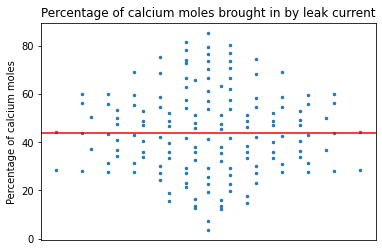

In [24]:
# Ca moles from leak and ICaL

# load the fraction
dat = pd.read_csv('resources/ca_leak_frac.csv')['leak moles frac']
average = round(100 * dat.median())
print(f'On an average, {average }% of the calcium moles are brought in by the leak current (marked by a red line)')

dat = dat.values.tolist()
dat = [x*100 for x in dat]

x_arr = extensions.simple_beeswarm(dat)

fig = plt.figure(facecolor='white')

plt.scatter(x_arr, dat, s=6)

plt.title('Percentage of calcium moles brought in by leak current')
plt.ylabel('Percentage of calcium moles')
plt.axhline(y=average, color = 'red')
plt.xticks([])
plt.show()
plt.close()

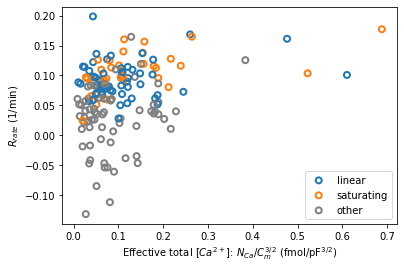

In [29]:
# The relationship between the rundown rate and effective calcium concentration is weakly linear

rrate_data = pd.read_csv('output/r_rate_database.csv')
cal_data = pd.read_csv('resources/ca_leak_frac.csv')

ca_conc = cal_data['Ca_eff']
color_map = {'Linear': '#1f77b4', 'Saturating': '#ff7f0e', 'Other': 'grey'}

fig = plt.figure(facecolor='white')
for i in  range(len(rrate_data)):
    r_rate = rrate_data['Run rate'].iloc[i]
    shape = rrate_data['shape'].iloc[i]

    ca = ca_conc.iloc[i]

    plt.scatter(ca, r_rate, edgecolors = color_map[shape], lw = 2, facecolors = 'none')

plt.scatter([], [], edgecolors = color_map['Linear'], lw = 2, facecolors = 'none', label = 'linear')
plt.scatter([], [], edgecolors = color_map['Saturating'], lw = 2, facecolors = 'none', label = 'saturating')
plt.scatter([], [], edgecolors = color_map['Other'], lw = 2, facecolors = 'none', label = 'other' )

plt.ylabel('$R_{rate}$ (1/min)')
plt.xlabel('Effective total $[{Ca}^{2+}]$: $N_{Ca}$/$C_{m}^{{3}/{2}}$ (fmol/$\mathrm{pF}^{3/2}$)')
plt.legend()
plt.show()
plt.close()